<h1><center>Applied Data Science Capstone</center></h1>

## Project Name: Toronto Neighborhood Clustering and Segmentation

Objective of this project is to explore Toronto neighborhoods and cluster them based on the venues and segment them using Wikipedia Data and Foursqaure API.

### <font color='red'> CLICK on the link to navigate to specific sections</font>


## Table of Contents 

<font size = 3>
    
1. <a href="#item1">Web Scraping using BeautifulSoup</a> 

2. <a href="#item2">Collecting Neighborhood Latitude and Longitude Coordinates</a>

3. <a href="#item3">Explore and cluster the neighborhoods in Toronto</a>

</font>


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

<a id='item1'></a>
# <font color='blue'>1. Web Scraping using BeautifulSoup </font>
This section demonstrates usage of BeautifulSoup to collect Toronto beighborhood data from Wikipedia page.
Notes:
* if we examine the BeautifulSoup output then we can notice that the Wiki Page contains a table of class named 'wikitable'

#### 1.1 Wiki Page content and get the rows of the table

In [2]:
wikiUrl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikiResp = requests.get(wikiUrl) # Get response from wikipedia 
soup = BeautifulSoup(wikiResp.content) # Process the response
table = soup.find('table', {"class":"wikitable"}) # Find the table
tableRows = table.findAll('tr') # Get all Rows of the table
print('# Rows in table:', len(tableRows))
tableRows[0:2]  # output just two rows for reference

# Rows in table: 181


[<tr>
 <th>Postal code
 </th>
 <th>Borough
 </th>
 <th>Neighborhood
 </th></tr>, <tr>
 <td>M1A
 </td>
 <td>Not assigned
 </td>
 <td>
 </td></tr>]

##### <font color='red'>Note: "th" and "td" tag usage</font>

#### 1.2 Build a dataframe and Ignore rows with empty cells
* Ignore cells with a borough that is Not assigned
* Set Neighborhood = Borough, If a cell has a borough but a Not assigned neighborhood

In [3]:
# Create Empty DataFrame with required columns
torontoNB = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

# Iterate all row elements and collect the data
# ignore the first row of wikitable as it the title row
for rowIndex, rowElement in enumerate(tableRows[1:]):
    # initialize row values as empty strings
    postalCode = ''
    borough = ''
    neighborhood = ''
    # get the cell values
    cells = rowElement.findAll('td')
    postalCode = cells[0].text.strip()
    borough = cells[1].text.strip()
    neighborhood = cells[2].text.strip() if cells[2].text.strip() else borough # if neighborhood not assigned, set to borough
    
    # add the row to data frame if is not equals 'Not assigned'
    if borough.lower() != 'not assigned':
        torontoNB.loc[len(torontoNB)] = [postalCode, borough, neighborhood]

#### 1.3 Check and Cleanup duplicate postal codes

* Check if More than one neighborhood can exist in one postal code area

In [4]:
# Check the postal code counts
print('# Unique Postal Codes:', torontoNB.PostalCode.unique().shape[0])
print('# Rows in torontoNB:', torontoNB.shape[0])

# Unique Postal Codes: 103
# Rows in torontoNB: 103


<font color='red'> Note:  

* <font color='red'>Filtering rules implemented step 1.2</font>

* <font color='red'>At Step 1.3 there is NO row with 'Not assigned' Borough.</font>

* <font color='red'>At Step 1.3 there is NO Duplicate PostalCode, Refer Unique Postal Codes and total length of dataframe.</font>

</font>

#### 1.4 Display Toronto Neighborhood data


In [5]:
print('DataFrame Shape:', torontoNB.shape)
torontoNB.head()

DataFrame Shape: (103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


<a id='item2'></a>
# <font color='blue'>2. Collecting Neighborhood Latitude and Longitude Coordinates</font>
In this section, we will get Toronto neighborhood latitude and longitude coordinates from pre defined csv file

#### 2.1 Read latitude and logitude data from csv

In [6]:
trnbll_CsvUrl = 'http://cocl.us/Geospatial_data'
trnbll_csv_df = pd.read_csv(trnbll_CsvUrl)
trnbll_csv_df.rename(columns={'Postal Code':'PostalCode'} , inplace=True)
print(trnbll_csv_df.shape)

(103, 3)


#### 2.2 Collect location coordinates and Display results

In [7]:
torontoNBLoc = torontoNB.join(trnbll_csv_df.set_index('PostalCode'), on='PostalCode')
print(torontoNBLoc.shape)
torontoNBLoc.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


<a id='item3'></a>
# <font color='blue'>3. Explore and cluster the neighborhoods in Toronto</font>

## 3.1 Filter/Select boroughs names containing 'Toronto'

In [8]:
neighborhoods = torontoNBLoc.copy()
neighborhoods['borough_lower'] = neighborhoods.Borough.str.lower()
neighborhoods = neighborhoods[neighborhoods['borough_lower'].str.contains('toronto')]
neighborhoods = neighborhoods.drop('borough_lower', 1)
neighborhoods.reset_index(inplace=True, drop='index')
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
1,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [9]:
print('# Boroughs:', len(neighborhoods.Borough.unique()))
print('# Neighborhoods:', neighborhoods.shape[0])

# Boroughs: 4
# Neighborhoods: 39


## 3.2 Get Toronto Coordinates

In [10]:
geolocator = Nominatim(user_agent="my-application")
toLoc = geolocator.geocode('North Toronto West, Ontario') # Using 'North Toronto West' to center map around Toronto neighborhoods
toLatitude = toLoc.latitude
toLongitude = toLoc.longitude
print('Toronto Latitude, Longitude:', toLatitude, toLongitude)

Toronto Latitude, Longitude: 43.6465466 -79.4195263


## 3.3 Visualize Neighborhoods on Map

In [12]:
# Create Toronto Map
toMap = folium.Map(location=[toLatitude, toLongitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toMap)  

toMap

## 3.4 Explore Toronto Neighborhoods
Using Foursquare API and Neighborhood Locations gathered earlier
With radius limit of 500 meters
Max number of places per neighborhood is 100

### 3.4.1 Get Foursquare User Details 
<font color = 'red'>
In this section we will collect user's Foursquare Client ID and Client Secret.
This will avoid hard coding of the credentials.
Method I'll follow is to store as Windows Environment Variables and read them.
</font>

In [13]:
import os
CLIENT_ID = os.environ.get("FS_CLIENT_ID")
CLIENT_SECRET = os.environ.get("FS_CLIENT_SECRET")
print(type(CLIENT_ID))
print(type(CLIENT_SECRET))

<class 'str'>
<class 'str'>


### 3.4.2 Foursquare API Query Function

In [14]:
# Foursquare Setup
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

# Function to gather venue name, location and category (Reusing the same function defined in previous lab)
# change made is to include the postal code column
def getNearbyVenues(postalcodes, names, latitudes, longitudes):
    
    venues_list=[]
    for postalcode, name, lat, lng in zip(postalcodes, names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url)
        #print(resp)
        results = resp.json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                             'Neighborhood', 
                              'Neighborhood Latitude', 
                              'Neighborhood Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
    
    return(nearby_venues)

### 3.4.3 Collect Venue details for all neighborhoods
Using Neighborhood Locations gathered in step 3.1

In [17]:
venues = getNearbyVenues(postalcodes=neighborhoods['PostalCode'],
                        names=neighborhoods['Neighborhood'],
                        latitudes=neighborhoods['Latitude'],
                        longitudes=neighborhoods['Longitude']
                        )

# Remove Venues which are categorized as 'Neighborhood'
venues = venues[venues['Venue Category']!='Neighborhood'] 
venues.reset_index(inplace=True, drop='index')

venues.head(2)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,Regent Park / Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Regent Park / Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop


Visualize venue details

In [18]:
print('# Venues:', venues.shape[0])
print('# Unique Venue Categories:', len(venues['Venue Category'].unique()))
print('# Neighborhoods:', len(venues['Neighborhood'].unique()))

# Venues: 1679
# Unique Venue Categories: 232
# Neighborhoods: 39


## 3.5 Analyze Each Neighborhood

### 3.5.1 Perform one hot encoding of venue categories

In [19]:
# one hot encoding
venueOneHot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
print(venueOneHot.shape)
# add neighborhood column back to dataframe
venueOneHot['Neighborhood'] = venues['Neighborhood'] 
# move neighborhood column to the first column
rearrangedColumns = [venueOneHot.columns[-1]] + list(venueOneHot.columns[:-1])
venueOneHot = venueOneHot[rearrangedColumns]

print(venueOneHot.shape)
venueOneHot.head(2)

(1679, 232)
(1679, 233)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Regent Park / Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Regent Park / Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.5.2 Group by Neighborhood and calculate mean of the frequency of occurrence of each category

In [22]:
venueByNB= venueOneHot.groupby('Neighborhood').mean().reset_index()
print(venueByNB.shape)
venueByNB.head(2)

(39, 233)


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0,0.000000
1,Brockton / Parkdale Village / Exhibition Place,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.043478


### 3.5.3 Prepare Dataframe with most occuring venue categories for each neighborhood

In [23]:
# Function to Sort Most Common Venue for each neighborhood
def get_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

# create columns according to number of top venues
indicators = ['st', 'nd', 'rd']
topVenueDfColumns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        topVenueDfColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        topVenueDfColumns.append('{}th Most Common Venue'.format(ind+1))
#print(topVenueDfColumns)

# create a new dataframe
topCommonVenues = pd.DataFrame(columns=topVenueDfColumns)
topCommonVenues['Neighborhood'] = venueByNB['Neighborhood']

# Sort Most Common Venue for each neighborhood
for ind in np.arange(venueByNB.shape[0]):
    topCommonVenues.iloc[ind, 1:] = get_most_common_venues(venueByNB.iloc[ind, :], num_top_venues)
    
print(topCommonVenues.shape)
topCommonVenues.head(2)

(39, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Farmers Market,Beer Bar,Café,Cheese Shop,Restaurant,Liquor Store
1,Brockton / Parkdale Village / Exhibition Place,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant,Intersection


## 3.6 Cluster Neighborhoods

### 3.6.1 Build Models for different K values
Iteratively create clusters from minK to maxK and collect the accuracies to plot and choose best K and corressponding cluster

K, SSE and Drop of SSE Reduction:
2 3.010722384850601 0.9781280033989508
3 2.4675919045627412 0.5431304802878598
4 1.9656765335966548 0.5019153709660864
5 1.7169248530783852 0.24875168051826968
6 1.4488669227782123 0.2680579303001729
7 1.2544224783337679 0.19444444444444442
8 1.1576183028790208 0.09680417545474707
9 1.0447454674649737 0.11287283541404713
10 0.9727997994954576 0.07194566796951607


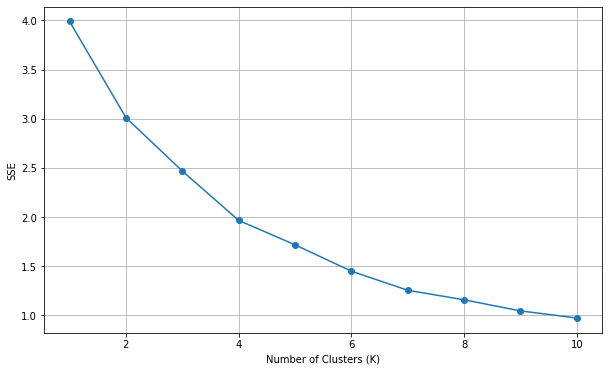

In [41]:
minK = 1
maxK = 10
inputData = venueByNB.drop('Neighborhood', 1)

kList = list(range(minK, maxK+1))
models = []
sseList = []  # inertia_ = SSE i.e, Sum of squared distances of data points to their closest cluster center

for numClusters in kList:
    kMeansModel = KMeans(init = "k-means++", n_clusters = numClusters, random_state=3)
    kMeansModel.fit(inputData)
    models.append(kMeansModel)
    sseList.append(kMeansModel.inertia_) 

print('K, SSE and Drop of SSE Reduction:')
for i in range(1, len(kList)):
    print(i+1, sseList[i], sseList[i-1]-sseList[i])
    
# Plot SSE vs Number of Clusters
fig = plt.figure(figsize=(10, 6))
ax=fig.add_subplot(1, 1, 1)
ax.plot(kList, sseList, marker='o')
ax.set_ylabel('SSE')
ax.set_xlabel('Number of Clusters (K)')
ax.grid(True, which='major', axis='both')

##### <font color='red'> From above plot we could choose 4 as good number of clusters.</font>
  

In [47]:
bestK = 4
bestKMeansModel = models[bestK-1]
#print(bestKMeansModel.labels_.shape)
bestKMeansModel.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 2, 3,
       3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

### 3.6.4. Visualize Clusters

#### Add Cluster labels to top common venues dataframe

In [48]:
topVenuesAndLabels = topCommonVenues.copy()
topVenuesAndLabels.insert(0, 'Cluster Labels', bestKMeansModel.labels_)
topVenuesAndLabels.head(2)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Farmers Market,Beer Bar,Café,Cheese Shop,Restaurant,Liquor Store
1,3,Brockton / Parkdale Village / Exhibition Place,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Grocery Store,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant,Intersection


#### Merge Labels, Top Common Venues,  Latitude and Longitude Coordinates

In [49]:
toMerged = neighborhoods.join(topVenuesAndLabels.set_index('Neighborhood'), on='Neighborhood')
toMerged['Cluster Labels'] = toMerged['Cluster Labels'].astype('int64')
toMerged.head(2)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,3,Coffee Shop,Bakery,Pub,Park,Theater,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Yoga Studio
1,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,3,Coffee Shop,Diner,Yoga Studio,Creperie,Mexican Restaurant,Juice Bar,Italian Restaurant,Hobby Shop,Fried Chicken Joint,Distribution Center


In [50]:
toMerged['Cluster Labels'].value_counts()

3    34
0     3
2     1
1     1
Name: Cluster Labels, dtype: int64

#### Display Neighborhood Clusters on Map

In [51]:
# Set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, bestK))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']

In [53]:
# Create Toronto Map
toClusterMap = folium.Map(location=[toLatitude, toLongitude], zoom_start=11)

# add markers to map
for lat, lon, nb, cluster in zip(toMerged['Latitude'], toMerged['Longitude'], toMerged['Neighborhood'], toMerged['Cluster Labels']):
    label = folium.Popup(str(nb) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster, rainbow[cluster])
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(toClusterMap)

toClusterMap

## 3.7 Review Clusters and Segment Neighborhoods

### 3.7.1 Examine Venues from Each Cluster
Let us look at 'Top Most Venue' of 5 'Neighborhoods' from each 'Cluster' and Assign Names to Clusters

In [68]:
for cid in range(0, bestK):
    clusterData = topVenuesAndLabels[topVenuesAndLabels['Cluster Labels'] == cid]['1st Most Common Venue'].to_list()
    print('Cluster #:', cid)
    print('\t# Neighborhoods in this cluster:', len(clusterData))
    print('\t1st Most Common Venues:', clusterData[0:5])
    print()

Cluster #: 0
	# Neighborhoods in this cluster: 3
	1st Most Common Venues: ['Park', 'Park', 'Park']

Cluster #: 1
	# Neighborhoods in this cluster: 1
	1st Most Common Venues: ['Pool']

Cluster #: 2
	# Neighborhoods in this cluster: 1
	1st Most Common Venues: ['Playground']

Cluster #: 3
	# Neighborhoods in this cluster: 34
	1st Most Common Venues: ['Coffee Shop', 'Café', 'Light Rail Station', 'Airport Service', 'Coffee Shop']



### 3.7.2 Segmentation (Naming Clusters)

<font color='red'> Note:  

* <font color='red'>Cluster 0 can be named as "Park"</font>

* <font color='red'>Cluster 1 can be named as "Pool"</font>

* <font color='red'>Cluster 2 can be named as "Playground"</font>

* <font color='red'>Cluster 3 can be named as "Shopping/Travel"</font>

</font>